# Imports and Variables

In [1]:
import os
import boto3
from botocore.exceptions import ClientError
import logging
import sagemaker
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
aws_user = os.environ['AWS_USER']
aws_key = os.environ['AWS_KEY']
region_name = 'eu-central-1'

session = boto3.session.Session(
    aws_access_key_id=aws_user,
    aws_secret_access_key=aws_key,
    region_name=region_name)

s3_client = session.client('s3')
s3 = session.resource('s3')

region_name = 'eu-central-1'
bucket_name = 'niy-certification'

role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

# Load all Data

In [3]:
def get_preproccessed_df(s3_link):
    df_raw = pd.read_csv(s3_link, dtype={'DAY_OF_MONTH': str, 'CRS_ARR_TIME': str, 'CRS_DEP_TIME': str})
    columns_to_drop = ['Unnamed: 54']
    # drop flights which are either canceled or diverted
    # as this is a conceptually different thing than being delayed
    
    df_raw = df_raw.drop(columns_to_drop, axis=1)
    
    return df_raw

In [4]:
base_path = 'https://niy-certification.s3.eu-central-1.amazonaws.com/usdot/'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
years = ['_2019_usdot.csv', '_2020_usdot.csv']

In [5]:
i = 0

for year in years:
    for month in months:
        if i == 0:
            df = get_preproccessed_df(base_path + month + year)
            print(df.shape)
        else:
            df_temp = get_preproccessed_df(base_path + month + year)
            df = df.append(df_temp)
            print(df.shape)
        i += 1

(638649, 54)
(1221615, 54)
(1910836, 54)
(2579095, 54)
(3273406, 54)
(3967875, 54)
(4685559, 54)
(5403015, 54)
(6063727, 54)
(6724283, 54)
(7347386, 54)
(8048660, 54)
(8379898, 54)
(8572310, 54)
(8809574, 54)
(9180433, 54)
(9578903, 54)
(9924197, 54)


In [6]:
df['YEARMONTH'] = df['YEAR'].astype(str) + '0' + df['MONTH'].astype(str)

In [7]:
df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'WHEELS_OFF', 'WHEELS_ON',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15',
       'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'YEARMONTH'],


In [8]:
df.loc[df['YEARMONTH'] == '202004', 'ARR_DELAY_NEW'].isna().sum()

137163

In [9]:
df.loc[df['YEARMONTH'] == '202004', 'CANCELLED'].value_counts()

0.0    194390
1.0    136848
Name: CANCELLED, dtype: int64

In [10]:
df.loc[df['YEARMONTH'] == '202004', 'ARR_DEL15'].count()

194075

In [11]:
df.loc[(df['YEARMONTH'] == '202004') &
       (df['CANCELLED'] == 0) &
       (df['DIVERTED'] == 0), 'ARR_DELAY_NEW'].count()

194075

# Counts

In [12]:
df.groupby('YEARMONTH')['FLIGHTS'].count()

YEARMONTH
201901    638649
201902    582966
201903    689221
201904    668259
201905    694311
201906    694469
201907    717684
201908    717456
201909    660712
202001    660556
202002    623103
202003    701274
202004    331238
202005    192412
202006    237264
202007    370859
202008    398470
202009    345294
Name: FLIGHTS, dtype: int64

As expected, the number of flights drastically decreased, once the lockdown was implemented early 2020.

# Delays

In [13]:
df.groupby('YEARMONTH')['ARR_DEL15'].count()

YEARMONTH
201901    617649
201902    562827
201903    674529
201904    650917
201905    677931
201906    677024
201907    700359
201908    702580
201909    648269
202001    650850
202002    615826
202003    582123
202004    194075
202005    179778
202006    235861
202007    367076
202008    393285
202009    342293
Name: ARR_DEL15, dtype: int64

In [17]:
df_no_cancellations = df.loc[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)].copy()

<AxesSubplot:xlabel='YEARMONTH'>

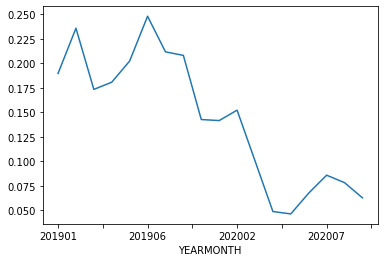

In [18]:
(df_no_cancellations.groupby('YEARMONTH')['ARR_DEL15'].sum() / df_no_cancellations.groupby('YEARMONTH')['ARR_DEL15'].count()).plot()

Interestingly enough, the percentage of delayed flights (defined as delayed with more than 15 minutes of delayed arrivals) also went down. One interpretation could be that with less flights, there were more available resources to take care of the ongoing flights.
The counterargument would have been that delays are caused by more structural issues (such as issues which is not impacted by CoVid-19) and thus the percentage of delays should be the same. However, at least some of the causes for delays seems to have been impacted by CoVid-19.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 0.5)

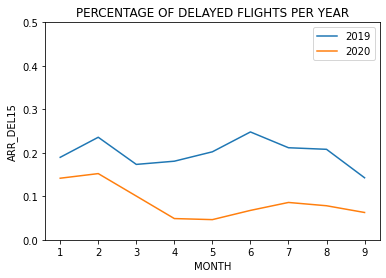

In [36]:
percent_delays_2019 = df_no_cancellations.loc[df_no_cancellations['YEAR'] == 2019].groupby('MONTH')['ARR_DEL15'].sum() / df_no_cancellations.loc[df_no_cancellations['YEAR'] == 2019].groupby('MONTH')['ARR_DEL15'].count()
percent_delays_2020 = df_no_cancellations.loc[df_no_cancellations['YEAR'] == 2020].groupby('MONTH')['ARR_DEL15'].sum() / df_no_cancellations.loc[df_no_cancellations['YEAR'] == 2020].groupby('MONTH')['ARR_DEL15'].count()

sns.lineplot(
    x=percent_delays_2019.index, y=percent_delays_2019, label='2019',
    markers=True, dashes=False)
sns.lineplot(
    x=percent_delays_2020.index, y=percent_delays_2020, label='2020',
    markers=True, dashes=False)
plt.title('PERCENTAGE OF DELAYED FLIGHTS PER YEAR')
plt.ylim(0, 0.5)

In [40]:
df.groupby('YEARMONTH')['ARR_DELAY_NEW'].describe()

,count,mean,std,min,25%,50%,75%,max
YEARMONTH,,,,,,,,
201901,617649.0,14.056019,48.432797,0.0,0.0,0.0,7.0,1707.0
201902,562827.0,17.592276,54.161604,0.0,0.0,0.0,13.0,2649.0
201903,674529.0,12.367092,44.466911,0.0,0.0,0.0,6.0,2923.0
201904,650917.0,13.723373,46.906094,0.0,0.0,0.0,6.0,2075.0
201905,677931.0,15.309995,48.518093,0.0,0.0,0.0,9.0,1724.0
201906,677024.0,19.196399,54.165790,0.0,0.0,0.0,14.0,2041.0
201907,700359.0,17.208252,55.067366,0.0,0.0,0.0,9.0,2350.0
201908,702580.0,16.008958,51.002450,0.0,0.0,0.0,9.0,1658.0
201909,648269.0,10.372083,40.707174,0.0,0.0,0.0,2.0,1744.0


In [41]:
df.loc[df['ARR_DELAY_NEW'] > 0].groupby('YEARMONTH')['ARR_DELAY_NEW'].describe()

,count,mean,std,min,25%,50%,75%,max
YEARMONTH,,,,,,,,
201901,213228.0,40.715506,75.560308,1.0,7.0,17.0,44.0,1707.0
201902,225563.0,43.896419,78.517532,1.0,8.0,20.0,49.0,2649.0
201903,223649.0,37.299349,70.948179,1.0,6.0,16.0,40.0,2923.0
201904,212643.0,42.008329,74.476451,1.0,7.0,18.0,48.0,2075.0
201905,241684.0,42.945003,73.595408,1.0,7.0,19.0,49.0,1724.0
201906,278798.0,46.615912,76.462357,1.0,8.0,21.0,56.0,2041.0
201907,251422.0,47.935161,83.511589,1.0,7.0,20.0,56.0,2350.0
201908,250781.0,44.850184,77.421300,1.0,7.0,20.0,52.0,1658.0
201909,179108.0,37.541037,70.553048,1.0,6.0,15.0,41.0,1744.0


# Cancellations

In [40]:
percent_cancellations_2019

MONTH
1    0.030611
2    0.031480
3    0.019677
4    0.023533
5    0.020374
6    0.021120
7    0.020633
8    0.017984
9    0.016717
Name: CANCELLED, dtype: float64

In [41]:
percent_cancellations_2020

MONTH
1    0.012741
2    0.009782
3    0.168659
4    0.413141
5    0.063723
6    0.004341
7    0.007890
8    0.010859
9    0.007307
Name: CANCELLED, dtype: float64

(0.0, 0.5)

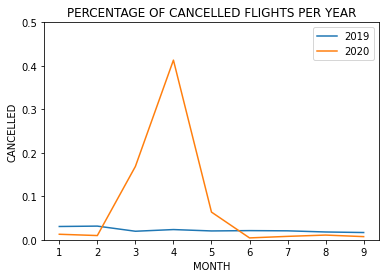

In [42]:
percent_cancellations_2019 = df.loc[df['YEAR'] == 2019].groupby('MONTH')['CANCELLED'].sum() / df.loc[df['YEAR'] == 2019].groupby('MONTH')['CANCELLED'].count()
percent_cancellations_2020 = df.loc[df['YEAR'] == 2020].groupby('MONTH')['CANCELLED'].sum() / df.loc[df['YEAR'] == 2020].groupby('MONTH')['CANCELLED'].count()

sns.lineplot(
    x=percent_cancellations_2019.index, y=percent_cancellations_2019, label='2019',
    markers=True, dashes=False)
sns.lineplot(
    x=percent_cancellations_2020.index, y=percent_cancellations_2020, label='2020',
    markers=True, dashes=False)
plt.title('PERCENTAGE OF CANCELLED FLIGHTS PER YEAR')
plt.ylim(0, 0.5)

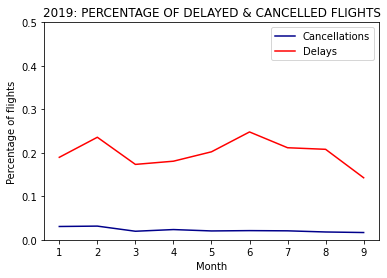

In [58]:
sns.lineplot(
    x=percent_cancellations_2019.index, y=percent_cancellations_2019, label='Cancellations',
    markers=True, dashes=False, color='darkblue')
sns.lineplot(
    x=percent_delays_2019.index, y=percent_delays_2019, label='Delays',
    markers=True, dashes=False, color='red')
plt.title('2019: PERCENTAGE OF DELAYED & CANCELLED FLIGHTS')
plt.ylim(0, 0.5)
plt.xlabel("Month")
plt.ylabel("Percentage of flights");

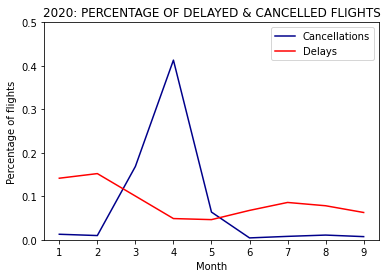

In [57]:
sns.lineplot(
    x=percent_cancellations_2020.index, y=percent_cancellations_2020, label='Cancellations',
    markers=True, dashes=False, color='darkblue')
sns.lineplot(
    x=percent_delays_2020.index, y=percent_delays_2020, label='Delays',
    markers=True, dashes=False, color='red')
plt.title('2020: PERCENTAGE OF DELAYED & CANCELLED FLIGHTS')
plt.ylim(0, 0.5)
plt.xlabel("Month")
plt.ylabel("Percentage of flights");

<AxesSubplot:xlabel='YEARMONTH'>

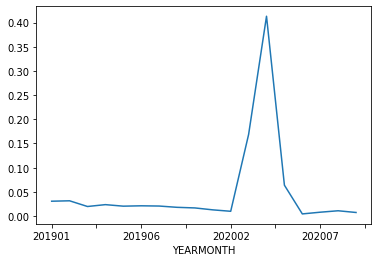

In [43]:
(df.groupby('YEARMONTH')['CANCELLED'].sum() / df.groupby('YEARMONTH')['CANCELLED'].count()).plot()

The number of cancellations skyrocketed in the months of march and april and quickly adapted to a regular level. In these months our models would not have answered the correct question.

# Divertions

<AxesSubplot:xlabel='YEARMONTH'>

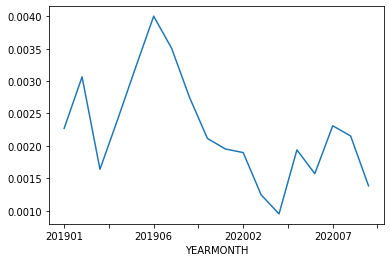

In [55]:
(df.groupby('YEARMONTH')['DIVERTED'].sum() / df.groupby('YEARMONTH')['DIVERTED'].count()).plot()